# Define a model for SER

In [1]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, LSTM, TimeDistributed, InputLayer, Reshape, BatchNormalization

2022-10-31 15:48:45.136729: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
def create_model():
    m = Sequential([
        InputLayer(input_shape=(256,256,3)),
        Reshape((8,32,256,3)),
        TimeDistributed(Conv2D(16, kernel_size=(3,3), activation='relu', strides=(1))),
        TimeDistributed(BatchNormalization()),
        TimeDistributed(MaxPooling2D(pool_size=(2,2))),
        TimeDistributed(Conv2D(32, kernel_size=(3,3), activation='relu', strides=(1))),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2))),
        TimeDistributed(Conv2D(64, kernel_size=(3,3), activation='relu', strides=(1))),
        TimeDistributed(MaxPooling2D(pool_size=(2,2), strides=(2))),

        TimeDistributed(Flatten()),
        Dropout(0.2),
        LSTM(128, return_sequences=True),
        Flatten(),
        Dense(7, activation='softmax')
    ])

    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #.summary()
    return m

In [3]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model)

# EmoDB

Import data for train/test

In [4]:
import numpy as np
import pandas as pd
x = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/x_im.npy')
y = np.load('/datasets/nicolas_facchinetti/processed_data/EmoDB/first_experiment/y_im.npy')
metadata = pd.read_csv('/datasets/nicolas_facchinetti/processed_data/EmoDB/processed_metadata.csv')

In [5]:
metadata, x.shape, y.shape

(                                              filepath     filename  chunk  \
 0    /datasets/nicolas_facchinetti/EmoDB/data/13a05...  13a05Tc.wav      0   
 1    /datasets/nicolas_facchinetti/EmoDB/data/14b09...  14b09Ac.wav      0   
 2    /datasets/nicolas_facchinetti/EmoDB/data/11b02...  11b02Na.wav      0   
 3    /datasets/nicolas_facchinetti/EmoDB/data/09b03...  09b03Fd.wav      0   
 4    /datasets/nicolas_facchinetti/EmoDB/data/16b10...  16b10Fb.wav      0   
 ..                                                 ...          ...    ...   
 560  /datasets/nicolas_facchinetti/EmoDB/data/11b03...  11b03Td.wav      0   
 561  /datasets/nicolas_facchinetti/EmoDB/data/11b03...  11b03Td.wav      1   
 562  /datasets/nicolas_facchinetti/EmoDB/data/12b02...  12b02Na.wav      0   
 563  /datasets/nicolas_facchinetti/EmoDB/data/14b01...  14b01Eb.wav      0   
 564  /datasets/nicolas_facchinetti/EmoDB/data/08b01...  08b01Fe.wav      0   
 
          label  actor gender  length  
 0      Sa

In [6]:
def leave_one_speaker_out(data, n=5):
    speakers = data.actor.unique()
    # random select n actors as test
    selected = np.random.choice(speakers, size=n, replace=False)
    
    myCViterator = []
    for i in selected:
        trainIndices = data[data['actor']!=i ].index.values.astype(int)
        testIndices =  data[data['actor']==i ].index.values.astype(int)
        myCViterator.append((trainIndices, testIndices))
    return myCViterator

In [7]:
indices = leave_one_speaker_out(metadata, n=1)
train_idx = indices[0][0]
test_idx = indices[0][1]
train_idx, metadata.iloc[train_idx]

(array([  1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
         69,  70,  71,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
         96,  97,  99, 101, 102, 103, 104, 105, 106, 108, 109, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 154, 157, 159,
        160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 173,
        174, 175, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187,
        188, 189, 190, 191, 192, 193, 194, 195, 197

In [8]:
cv_train = leave_one_speaker_out(metadata.iloc[train_idx], n=3)

In [9]:
from sklearn.model_selection import GridSearchCV
# define the grid search parameters
batch_size = [8, 16, 32, 64, 128]
epochs = [30, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv_train)

In [10]:
grid_result = grid.fit(x, y)

2022-10-31 15:48:55.773689: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-31 15:48:55.774584: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-10-31 15:48:55.829080: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:15:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.78GiB deviceMemoryBandwidth: 607.97GiB/s
2022-10-31 15:48:55.829107: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-10-31 15:48:55.830719: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-31 15:48:55.830777: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2022-1

Epoch 1/30


2022-10-31 15:48:58.020094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-10-31 15:48:58.216265: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


54/54 [==============================] - 3s 12ms/step - loss: 2.1141 - accuracy: 0.2504
Epoch 2/30
54/54 [==============================] - 1s 11ms/step - loss: 1.3430 - accuracy: 0.5334
Epoch 3/30
54/54 [==============================] - 1s 11ms/step - loss: 0.9969 - accuracy: 0.6407
Epoch 4/30
54/54 [==============================] - 1s 11ms/step - loss: 0.8713 - accuracy: 0.6742
Epoch 5/30
54/54 [==============================] - 1s 11ms/step - loss: 0.5509 - accuracy: 0.8092
Epoch 6/30
54/54 [==============================] - 1s 11ms/step - loss: 0.3525 - accuracy: 0.9317
Epoch 7/30
54/54 [==============================] - 1s 11ms/step - loss: 0.1575 - accuracy: 0.9910
Epoch 8/30
54/54 [==============================] - 1s 11ms/step - loss: 0.0800 - accuracy: 1.0000
Epoch 9/30
54/54 [==============================] - 1s 11ms/step - loss: 0.0344 - accuracy: 1.0000
Epoch 10/30
54/54 [==============================] - 1s 11ms/step - loss: 0.0178 - accuracy: 1.0000
Epoch 11/30
54/54 [=

59/59 [==============================] - 1s 11ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 22/30
59/59 [==============================] - 1s 11ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 23/30
59/59 [==============================] - 1s 11ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 24/30
59/59 [==============================] - 1s 11ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 25/30
59/59 [==============================] - 1s 11ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 26/30
59/59 [==============================] - 1s 11ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 27/30
59/59 [==============================] - 1s 11ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 28/30
59/59 [==============================] - 1s 11ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 29/30
59/59 [==============================] - 1s 11ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 30/30
5/5 [==============================] - 0s 4ms/step - loss: 1.3529 - accuracy: 0.5263
Epoch 1/50
54/5

58/58 [==============================] - 1s 11ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 21/50
58/58 [==============================] - 1s 11ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 22/50
58/58 [==============================] - 1s 11ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 23/50
58/58 [==============================] - 1s 11ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 24/50
58/58 [==============================] - 1s 11ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 25/50
58/58 [==============================] - 1s 11ms/step - loss: 9.8012e-04 - accuracy: 1.0000
Epoch 26/50
58/58 [==============================] - 1s 11ms/step - loss: 9.0681e-04 - accuracy: 1.0000
Epoch 27/50
58/58 [==============================] - 1s 11ms/step - loss: 8.6242e-04 - accuracy: 1.0000
Epoch 28/50
58/58 [==============================] - 1s 11ms/step - loss: 6.9953e-04 - accuracy: 1.0000
Epoch 29/50
58/58 [==============================] - 1s 11ms/step - loss: 6.3476e-04 - accuracy:

59/59 [==============================] - 1s 11ms/step - loss: 1.9118e-04 - accuracy: 1.0000
Epoch 50/50
5/5 [==============================] - 0s 5ms/step - loss: 1.6286 - accuracy: 0.5263
Epoch 1/100
54/54 [==============================] - 2s 10ms/step - loss: 1.8977 - accuracy: 0.2902
Epoch 2/100
54/54 [==============================] - 1s 11ms/step - loss: 1.3288 - accuracy: 0.5053
Epoch 3/100
54/54 [==============================] - 1s 11ms/step - loss: 1.0800 - accuracy: 0.5820
Epoch 4/100
54/54 [==============================] - 1s 11ms/step - loss: 0.7840 - accuracy: 0.7182
Epoch 5/100
54/54 [==============================] - 1s 11ms/step - loss: 0.5806 - accuracy: 0.8584
Epoch 6/100
54/54 [==============================] - 1s 11ms/step - loss: 0.3942 - accuracy: 0.8945
Epoch 7/100
54/54 [==============================] - 1s 11ms/step - loss: 0.2794 - accuracy: 0.9494
Epoch 8/100
54/54 [==============================] - 1s 11ms/step - loss: 0.1429 - accuracy: 0.9867
Epoch 9/100

54/54 [==============================] - 1s 11ms/step - loss: 6.2405e-05 - accuracy: 1.0000
Epoch 78/100
54/54 [==============================] - 1s 11ms/step - loss: 5.6331e-05 - accuracy: 1.0000
Epoch 79/100
54/54 [==============================] - 1s 11ms/step - loss: 5.6593e-05 - accuracy: 1.0000
Epoch 80/100
54/54 [==============================] - 1s 11ms/step - loss: 4.8546e-05 - accuracy: 1.0000
Epoch 81/100
54/54 [==============================] - 1s 11ms/step - loss: 4.8455e-05 - accuracy: 1.0000
Epoch 82/100
54/54 [==============================] - 1s 11ms/step - loss: 5.1990e-05 - accuracy: 1.0000
Epoch 83/100
54/54 [==============================] - 1s 11ms/step - loss: 4.5064e-05 - accuracy: 1.0000
Epoch 84/100
54/54 [==============================] - 1s 11ms/step - loss: 4.6615e-05 - accuracy: 1.0000
Epoch 85/100
54/54 [==============================] - 1s 11ms/step - loss: 4.2177e-05 - accuracy: 1.0000
Epoch 86/100
54/54 [==============================] - 1s 11ms/step -

58/58 [==============================] - 1s 11ms/step - loss: 1.9366e-04 - accuracy: 1.0000
Epoch 56/100
58/58 [==============================] - 1s 11ms/step - loss: 1.6886e-04 - accuracy: 1.0000
Epoch 57/100
58/58 [==============================] - 1s 11ms/step - loss: 1.6147e-04 - accuracy: 1.0000
Epoch 58/100
58/58 [==============================] - 1s 11ms/step - loss: 1.4940e-04 - accuracy: 1.0000
Epoch 59/100
58/58 [==============================] - 1s 11ms/step - loss: 1.4904e-04 - accuracy: 1.0000
Epoch 60/100
58/58 [==============================] - 1s 11ms/step - loss: 1.4768e-04 - accuracy: 1.0000
Epoch 61/100
58/58 [==============================] - 1s 11ms/step - loss: 1.3676e-04 - accuracy: 1.0000
Epoch 62/100
58/58 [==============================] - 1s 11ms/step - loss: 1.3498e-04 - accuracy: 1.0000
Epoch 63/100
58/58 [==============================] - 1s 11ms/step - loss: 1.4211e-04 - accuracy: 1.0000
Epoch 64/100
58/58 [==============================] - 1s 11ms/step -

59/59 [==============================] - 1s 11ms/step - loss: 6.8897e-04 - accuracy: 1.0000
Epoch 34/100
59/59 [==============================] - 1s 10ms/step - loss: 6.7274e-04 - accuracy: 1.0000
Epoch 35/100
59/59 [==============================] - 1s 11ms/step - loss: 5.8476e-04 - accuracy: 1.0000
Epoch 36/100
59/59 [==============================] - 1s 11ms/step - loss: 5.2327e-04 - accuracy: 1.0000
Epoch 37/100
59/59 [==============================] - 1s 11ms/step - loss: 4.9569e-04 - accuracy: 1.0000
Epoch 38/100
59/59 [==============================] - 1s 11ms/step - loss: 5.6721e-04 - accuracy: 1.0000
Epoch 39/100
59/59 [==============================] - 1s 11ms/step - loss: 4.9690e-04 - accuracy: 1.0000
Epoch 40/100
59/59 [==============================] - 1s 11ms/step - loss: 4.5734e-04 - accuracy: 1.0000
Epoch 41/100
59/59 [==============================] - 1s 11ms/step - loss: 4.2640e-04 - accuracy: 1.0000
Epoch 42/100
59/59 [==============================] - 1s 11ms/step -

27/27 [==============================] - 0s 17ms/step - loss: 0.0329 - accuracy: 1.0000
Epoch 11/30
27/27 [==============================] - 0s 17ms/step - loss: 0.0192 - accuracy: 1.0000
Epoch 12/30
27/27 [==============================] - 0s 17ms/step - loss: 0.0124 - accuracy: 1.0000
Epoch 13/30
27/27 [==============================] - 0s 17ms/step - loss: 0.0089 - accuracy: 1.0000
Epoch 14/30
27/27 [==============================] - 0s 17ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 15/30
27/27 [==============================] - 0s 18ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 16/30
27/27 [==============================] - 0s 16ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 17/30
27/27 [==============================] - 0s 17ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 18/30
27/27 [==============================] - 0s 17ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 19/30
27/27 [==============================] - 0s 17ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 20/30


3/3 [==============================] - 1s 5ms/step - loss: 1.0255 - accuracy: 0.6316
Epoch 1/50
27/27 [==============================] - 1s 15ms/step - loss: 2.0123 - accuracy: 0.2134
Epoch 2/50
27/27 [==============================] - 0s 17ms/step - loss: 1.3994 - accuracy: 0.4496
Epoch 3/50
27/27 [==============================] - 0s 17ms/step - loss: 1.0720 - accuracy: 0.5796
Epoch 4/50
27/27 [==============================] - 0s 17ms/step - loss: 0.7600 - accuracy: 0.7364
Epoch 5/50
27/27 [==============================] - 0s 16ms/step - loss: 0.5518 - accuracy: 0.8589
Epoch 6/50
27/27 [==============================] - 0s 18ms/step - loss: 0.3291 - accuracy: 0.9352
Epoch 7/50
27/27 [==============================] - 0s 17ms/step - loss: 0.1672 - accuracy: 0.9907
Epoch 8/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0900 - accuracy: 1.0000
Epoch 9/50
27/27 [==============================] - 0s 17ms/step - loss: 0.0397 - accuracy: 1.0000
Epoch 10/50
27/27 [=====

29/29 [==============================] - 0s 17ms/step - loss: 8.3636e-04 - accuracy: 1.0000
Epoch 30/50
29/29 [==============================] - 0s 17ms/step - loss: 7.3401e-04 - accuracy: 1.0000
Epoch 31/50
29/29 [==============================] - 0s 17ms/step - loss: 6.9270e-04 - accuracy: 1.0000
Epoch 32/50
29/29 [==============================] - 0s 17ms/step - loss: 6.5173e-04 - accuracy: 1.0000
Epoch 33/50
29/29 [==============================] - 0s 16ms/step - loss: 5.7151e-04 - accuracy: 1.0000
Epoch 34/50
29/29 [==============================] - 0s 17ms/step - loss: 4.9381e-04 - accuracy: 1.0000
Epoch 35/50
29/29 [==============================] - 1s 17ms/step - loss: 5.3578e-04 - accuracy: 1.0000
Epoch 36/50
29/29 [==============================] - 0s 17ms/step - loss: 4.9867e-04 - accuracy: 1.0000
Epoch 37/50
29/29 [==============================] - 0s 17ms/step - loss: 5.0581e-04 - accuracy: 1.0000
Epoch 38/50
29/29 [==============================] - 0s 17ms/step - loss: 4.

27/27 [==============================] - 0s 17ms/step - loss: 0.3088 - accuracy: 0.9553
Epoch 8/100
27/27 [==============================] - 0s 18ms/step - loss: 0.1698 - accuracy: 0.9844
Epoch 9/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0752 - accuracy: 0.9982
Epoch 10/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0493 - accuracy: 1.0000
Epoch 11/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0255 - accuracy: 1.0000
Epoch 12/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0161 - accuracy: 1.0000
Epoch 13/100
27/27 [==============================] - 0s 18ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 14/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0083 - accuracy: 1.0000
Epoch 15/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0066 - accuracy: 1.0000
Epoch 16/100
27/27 [==============================] - 0s 17ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch

27/27 [==============================] - 0s 17ms/step - loss: 7.2352e-05 - accuracy: 1.0000
Epoch 87/100
27/27 [==============================] - 0s 18ms/step - loss: 6.8609e-05 - accuracy: 1.0000
Epoch 88/100
27/27 [==============================] - 0s 16ms/step - loss: 6.3523e-05 - accuracy: 1.0000
Epoch 89/100
27/27 [==============================] - 0s 17ms/step - loss: 5.9838e-05 - accuracy: 1.0000
Epoch 90/100
27/27 [==============================] - 0s 18ms/step - loss: 6.3497e-05 - accuracy: 1.0000
Epoch 91/100
27/27 [==============================] - 0s 17ms/step - loss: 5.8721e-05 - accuracy: 1.0000
Epoch 92/100
27/27 [==============================] - 0s 17ms/step - loss: 5.9590e-05 - accuracy: 1.0000
Epoch 93/100
27/27 [==============================] - 0s 16ms/step - loss: 5.9009e-05 - accuracy: 1.0000
Epoch 94/100
27/27 [==============================] - 0s 17ms/step - loss: 4.8057e-05 - accuracy: 1.0000
Epoch 95/100
27/27 [==============================] - 0s 17ms/step -

29/29 [==============================] - 0s 17ms/step - loss: 1.6843e-04 - accuracy: 1.0000
Epoch 65/100
29/29 [==============================] - 0s 17ms/step - loss: 1.6209e-04 - accuracy: 1.0000
Epoch 66/100
29/29 [==============================] - 0s 17ms/step - loss: 1.5034e-04 - accuracy: 1.0000
Epoch 67/100
29/29 [==============================] - 0s 16ms/step - loss: 1.5102e-04 - accuracy: 1.0000
Epoch 68/100
29/29 [==============================] - 0s 17ms/step - loss: 1.4542e-04 - accuracy: 1.0000
Epoch 69/100
29/29 [==============================] - 0s 16ms/step - loss: 1.3448e-04 - accuracy: 1.0000
Epoch 70/100
29/29 [==============================] - 0s 17ms/step - loss: 1.3932e-04 - accuracy: 1.0000
Epoch 71/100
29/29 [==============================] - 0s 16ms/step - loss: 1.4105e-04 - accuracy: 1.0000
Epoch 72/100
29/29 [==============================] - 0s 17ms/step - loss: 1.1773e-04 - accuracy: 1.0000
Epoch 73/100
29/29 [==============================] - 0s 17ms/step -

30/30 [==============================] - 0s 17ms/step - loss: 3.7089e-04 - accuracy: 1.0000
Epoch 43/100
30/30 [==============================] - 1s 17ms/step - loss: 3.5698e-04 - accuracy: 1.0000
Epoch 44/100
30/30 [==============================] - 1s 17ms/step - loss: 3.0250e-04 - accuracy: 1.0000
Epoch 45/100
30/30 [==============================] - 1s 17ms/step - loss: 3.1916e-04 - accuracy: 1.0000
Epoch 46/100
30/30 [==============================] - 0s 17ms/step - loss: 2.6569e-04 - accuracy: 1.0000
Epoch 47/100
30/30 [==============================] - 1s 17ms/step - loss: 2.8165e-04 - accuracy: 1.0000
Epoch 48/100
30/30 [==============================] - 0s 16ms/step - loss: 2.5275e-04 - accuracy: 1.0000
Epoch 49/100
30/30 [==============================] - 1s 18ms/step - loss: 2.4553e-04 - accuracy: 1.0000
Epoch 50/100
30/30 [==============================] - 0s 15ms/step - loss: 2.5280e-04 - accuracy: 1.0000
Epoch 51/100
30/30 [==============================] - 0s 17ms/step -

14/14 [==============================] - 0s 26ms/step - loss: 0.0049 - accuracy: 1.0000
Epoch 21/30
14/14 [==============================] - 0s 27ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 22/30
14/14 [==============================] - 0s 27ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 23/30
14/14 [==============================] - 0s 25ms/step - loss: 0.0035 - accuracy: 1.0000
Epoch 24/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 25/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0029 - accuracy: 1.0000
Epoch 26/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 27/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 28/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 29/30
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 30/30


2/2 [==============================] - 0s 5ms/step - loss: 1.5421 - accuracy: 0.6316
Epoch 1/50
14/14 [==============================] - 2s 24ms/step - loss: 2.0648 - accuracy: 0.2094
Epoch 2/50
14/14 [==============================] - 0s 25ms/step - loss: 1.6193 - accuracy: 0.3807
Epoch 3/50
14/14 [==============================] - 0s 27ms/step - loss: 1.2437 - accuracy: 0.5193
Epoch 4/50
14/14 [==============================] - 0s 28ms/step - loss: 1.0630 - accuracy: 0.5730
Epoch 5/50
14/14 [==============================] - 0s 26ms/step - loss: 0.9344 - accuracy: 0.6562
Epoch 6/50
14/14 [==============================] - 0s 28ms/step - loss: 0.6946 - accuracy: 0.7868
Epoch 7/50
14/14 [==============================] - 0s 26ms/step - loss: 0.4683 - accuracy: 0.8878
Epoch 8/50
14/14 [==============================] - 0s 27ms/step - loss: 0.3018 - accuracy: 0.9531
Epoch 9/50
14/14 [==============================] - 0s 26ms/step - loss: 0.1593 - accuracy: 0.9992
Epoch 10/50
14/14 [=====

15/15 [==============================] - 0s 24ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 24/50
15/15 [==============================] - 0s 23ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 25/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0028 - accuracy: 1.0000
Epoch 26/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 27/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 28/50
15/15 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 29/50
15/15 [==============================] - 0s 28ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 30/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 31/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 32/50
15/15 [==============================] - 0s 27ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 33/50


15/15 [==============================] - 0s 26ms/step - loss: 9.4992e-04 - accuracy: 1.0000
Epoch 47/50
15/15 [==============================] - 0s 26ms/step - loss: 8.6440e-04 - accuracy: 1.0000
Epoch 48/50
15/15 [==============================] - 0s 26ms/step - loss: 8.1622e-04 - accuracy: 1.0000
Epoch 49/50
15/15 [==============================] - 0s 27ms/step - loss: 7.4444e-04 - accuracy: 1.0000
Epoch 50/50
2/2 [==============================] - 0s 6ms/step - loss: 1.2043 - accuracy: 0.6053
Epoch 1/100
14/14 [==============================] - 1s 23ms/step - loss: 2.0613 - accuracy: 0.1974
Epoch 2/100
14/14 [==============================] - 0s 28ms/step - loss: 1.6087 - accuracy: 0.3894
Epoch 3/100
14/14 [==============================] - 0s 29ms/step - loss: 1.3092 - accuracy: 0.5100
Epoch 4/100
14/14 [==============================] - 0s 26ms/step - loss: 1.0699 - accuracy: 0.5780
Epoch 5/100
14/14 [==============================] - 0s 27ms/step - loss: 0.8659 - accuracy: 0.7043

14/14 [==============================] - 0s 28ms/step - loss: 3.6374e-04 - accuracy: 1.0000
Epoch 69/100
14/14 [==============================] - 0s 26ms/step - loss: 3.7525e-04 - accuracy: 1.0000
Epoch 70/100
14/14 [==============================] - 0s 28ms/step - loss: 3.3768e-04 - accuracy: 1.0000
Epoch 71/100
14/14 [==============================] - 0s 26ms/step - loss: 3.4346e-04 - accuracy: 1.0000
Epoch 72/100
14/14 [==============================] - 0s 27ms/step - loss: 3.1373e-04 - accuracy: 1.0000
Epoch 73/100
14/14 [==============================] - 0s 26ms/step - loss: 3.0090e-04 - accuracy: 1.0000
Epoch 74/100
14/14 [==============================] - 0s 26ms/step - loss: 3.0718e-04 - accuracy: 1.0000
Epoch 75/100
14/14 [==============================] - 0s 27ms/step - loss: 2.9187e-04 - accuracy: 1.0000
Epoch 76/100
14/14 [==============================] - 0s 26ms/step - loss: 2.7638e-04 - accuracy: 1.0000
Epoch 77/100
14/14 [==============================] - 0s 28ms/step -

15/15 [==============================] - 0s 27ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 40/100
15/15 [==============================] - 0s 29ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 41/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 42/100
15/15 [==============================] - 0s 27ms/step - loss: 9.9413e-04 - accuracy: 1.0000
Epoch 43/100
15/15 [==============================] - 0s 27ms/step - loss: 9.6667e-04 - accuracy: 1.0000
Epoch 44/100
15/15 [==============================] - 0s 27ms/step - loss: 7.9803e-04 - accuracy: 1.0000
Epoch 45/100
15/15 [==============================] - 0s 27ms/step - loss: 8.3708e-04 - accuracy: 1.0000
Epoch 46/100
15/15 [==============================] - 0s 26ms/step - loss: 8.1466e-04 - accuracy: 1.0000
Epoch 47/100
15/15 [==============================] - 0s 26ms/step - loss: 7.5819e-04 - accuracy: 1.0000
Epoch 48/100
15/15 [==============================] - 0s 27ms/step - loss: 7.030

15/15 [==============================] - 0s 26ms/step - loss: 0.2972 - accuracy: 0.9472
Epoch 10/100
15/15 [==============================] - 0s 29ms/step - loss: 0.1829 - accuracy: 0.9855
Epoch 11/100
15/15 [==============================] - 0s 27ms/step - loss: 0.1059 - accuracy: 0.9982
Epoch 12/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0707 - accuracy: 1.0000
Epoch 13/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0435 - accuracy: 1.0000
Epoch 14/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0280 - accuracy: 1.0000
Epoch 15/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0200 - accuracy: 1.0000
Epoch 16/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0152 - accuracy: 1.0000
Epoch 17/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0123 - accuracy: 1.0000
Epoch 18/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0092 - accuracy: 1.0000
Epo

15/15 [==============================] - 0s 27ms/step - loss: 2.0516e-04 - accuracy: 1.0000
Epoch 89/100
15/15 [==============================] - 0s 26ms/step - loss: 2.1207e-04 - accuracy: 1.0000
Epoch 90/100
15/15 [==============================] - 0s 27ms/step - loss: 2.1465e-04 - accuracy: 1.0000
Epoch 91/100
15/15 [==============================] - 0s 26ms/step - loss: 1.9498e-04 - accuracy: 1.0000
Epoch 92/100
15/15 [==============================] - 0s 28ms/step - loss: 1.8991e-04 - accuracy: 1.0000
Epoch 93/100
15/15 [==============================] - 0s 29ms/step - loss: 1.8298e-04 - accuracy: 1.0000
Epoch 94/100
15/15 [==============================] - 0s 28ms/step - loss: 1.9310e-04 - accuracy: 1.0000
Epoch 95/100
15/15 [==============================] - 0s 29ms/step - loss: 1.8400e-04 - accuracy: 1.0000
Epoch 96/100
15/15 [==============================] - 0s 28ms/step - loss: 1.9299e-04 - accuracy: 1.0000
Epoch 97/100
15/15 [==============================] - 0s 28ms/step -

8/8 [==============================] - 0s 44ms/step - loss: 0.0180 - accuracy: 1.0000
Epoch 25/30
8/8 [==============================] - 0s 44ms/step - loss: 0.0130 - accuracy: 1.0000
Epoch 26/30
8/8 [==============================] - 0s 46ms/step - loss: 0.0121 - accuracy: 1.0000
Epoch 27/30
8/8 [==============================] - 0s 44ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 28/30
8/8 [==============================] - 0s 46ms/step - loss: 0.0098 - accuracy: 1.0000
Epoch 29/30
8/8 [==============================] - 0s 45ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 30/30
1/1 [==============================] - 1s 558ms/step - loss: 3.0021 - accuracy: 0.2000
Epoch 1/30
8/8 [==============================] - 1s 38ms/step - loss: 2.3592 - accuracy: 0.1925
Epoch 2/30
8/8 [==============================] - 0s 44ms/step - loss: 1.8281 - accuracy: 0.2629
Epoch 3/30
8/8 [==============================] - 0s 46ms/step - loss: 1.6202 - accuracy: 0.4185
Epoch 4/30
8/8 [==================

7/7 [==============================] - 0s 52ms/step - loss: 0.0040 - accuracy: 1.0000
Epoch 32/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 33/50
7/7 [==============================] - 0s 50ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 34/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 35/50
7/7 [==============================] - 0s 53ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 36/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 37/50
7/7 [==============================] - 0s 51ms/step - loss: 0.0027 - accuracy: 1.0000
Epoch 38/50
7/7 [==============================] - 0s 47ms/step - loss: 0.0025 - accuracy: 1.0000
Epoch 39/50
7/7 [==============================] - 0s 50ms/step - loss: 0.0023 - accuracy: 1.0000
Epoch 40/50
7/7 [==============================] - 0s 50ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 41/50
7/7 [===============

1/1 [==============================] - 0s 312ms/step - loss: 1.3676 - accuracy: 0.4444
Epoch 1/50
8/8 [==============================] - 1s 42ms/step - loss: 2.1686 - accuracy: 0.1570
Epoch 2/50
8/8 [==============================] - 0s 45ms/step - loss: 1.7996 - accuracy: 0.3815
Epoch 3/50
8/8 [==============================] - 0s 46ms/step - loss: 1.4749 - accuracy: 0.4601
Epoch 4/50
8/8 [==============================] - 0s 48ms/step - loss: 1.2667 - accuracy: 0.5262
Epoch 5/50
8/8 [==============================] - 0s 44ms/step - loss: 1.0438 - accuracy: 0.5924
Epoch 6/50
8/8 [==============================] - 0s 47ms/step - loss: 0.8267 - accuracy: 0.6891
Epoch 7/50
8/8 [==============================] - 0s 45ms/step - loss: 0.6453 - accuracy: 0.8023
Epoch 8/50
8/8 [==============================] - 0s 47ms/step - loss: 0.5472 - accuracy: 0.8115
Epoch 9/50
8/8 [==============================] - 0s 49ms/step - loss: 0.5034 - accuracy: 0.8650
Epoch 10/50
8/8 [=======================

7/7 [==============================] - 0s 47ms/step - loss: 0.0118 - accuracy: 1.0000
Epoch 26/100
7/7 [==============================] - 0s 53ms/step - loss: 0.0111 - accuracy: 1.0000
Epoch 27/100
7/7 [==============================] - 0s 50ms/step - loss: 0.0101 - accuracy: 1.0000
Epoch 28/100
7/7 [==============================] - 0s 51ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 29/100
7/7 [==============================] - 0s 46ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 30/100
7/7 [==============================] - 0s 49ms/step - loss: 0.0072 - accuracy: 1.0000
Epoch 31/100
7/7 [==============================] - 0s 53ms/step - loss: 0.0063 - accuracy: 1.0000
Epoch 32/100
7/7 [==============================] - 0s 52ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 33/100
7/7 [==============================] - 0s 48ms/step - loss: 0.0054 - accuracy: 1.0000
Epoch 34/100
7/7 [==============================] - 0s 50ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 35/100
7/7 [=====

2/2 [==============================] - 0s 6ms/step - loss: 1.0712 - accuracy: 0.6712
Epoch 1/100
8/8 [==============================] - 1s 43ms/step - loss: 2.1648 - accuracy: 0.1958
Epoch 2/100
8/8 [==============================] - 0s 46ms/step - loss: 1.6995 - accuracy: 0.4109
Epoch 3/100
8/8 [==============================] - 0s 48ms/step - loss: 1.4071 - accuracy: 0.4952
Epoch 4/100
8/8 [==============================] - 0s 47ms/step - loss: 1.2249 - accuracy: 0.5657
Epoch 5/100
8/8 [==============================] - 0s 44ms/step - loss: 1.1120 - accuracy: 0.5978
Epoch 6/100
8/8 [==============================] - 0s 45ms/step - loss: 0.9269 - accuracy: 0.6946
Epoch 7/100
8/8 [==============================] - 0s 48ms/step - loss: 0.7962 - accuracy: 0.7552
Epoch 8/100
8/8 [==============================] - 0s 46ms/step - loss: 0.6493 - accuracy: 0.7865
Epoch 9/100
8/8 [==============================] - 0s 48ms/step - loss: 0.5199 - accuracy: 0.8650
Epoch 10/100
8/8 [===============

8/8 [==============================] - 0s 45ms/step - loss: 6.5508e-04 - accuracy: 1.0000
Epoch 83/100
8/8 [==============================] - 0s 45ms/step - loss: 6.7073e-04 - accuracy: 1.0000
Epoch 84/100
8/8 [==============================] - 0s 48ms/step - loss: 6.1717e-04 - accuracy: 1.0000
Epoch 85/100
8/8 [==============================] - 0s 49ms/step - loss: 6.0600e-04 - accuracy: 1.0000
Epoch 86/100
8/8 [==============================] - 0s 46ms/step - loss: 6.3118e-04 - accuracy: 1.0000
Epoch 87/100
8/8 [==============================] - 0s 50ms/step - loss: 6.0900e-04 - accuracy: 1.0000
Epoch 88/100
8/8 [==============================] - 0s 47ms/step - loss: 5.9150e-04 - accuracy: 1.0000
Epoch 89/100
8/8 [==============================] - 0s 44ms/step - loss: 6.1367e-04 - accuracy: 1.0000
Epoch 90/100
8/8 [==============================] - 0s 46ms/step - loss: 5.5369e-04 - accuracy: 1.0000
Epoch 91/100
8/8 [==============================] - 0s 49ms/step - loss: 5.4742e-04 - 

8/8 [==============================] - 0s 48ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 56/100
8/8 [==============================] - 0s 47ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 57/100
8/8 [==============================] - 0s 44ms/step - loss: 0.0011 - accuracy: 1.0000
Epoch 58/100
8/8 [==============================] - 0s 48ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 59/100
8/8 [==============================] - 0s 46ms/step - loss: 0.0010 - accuracy: 1.0000
Epoch 60/100
8/8 [==============================] - 0s 47ms/step - loss: 9.6469e-04 - accuracy: 1.0000
Epoch 61/100
8/8 [==============================] - 0s 48ms/step - loss: 9.7883e-04 - accuracy: 1.0000
Epoch 62/100
8/8 [==============================] - 0s 49ms/step - loss: 9.1813e-04 - accuracy: 1.0000
Epoch 63/100
8/8 [==============================] - 0s 46ms/step - loss: 8.3778e-04 - accuracy: 1.0000
Epoch 64/100
8/8 [==============================] - 0s 48ms/step - loss: 8.2437e-04 - accuracy: 1.0000
Epo

4/4 [==============================] - 0s 70ms/step - loss: 0.0134 - accuracy: 1.0000
Epoch 29/30
4/4 [==============================] - 0s 71ms/step - loss: 0.0115 - accuracy: 1.0000
Epoch 30/30
1/1 [==============================] - 0s 353ms/step - loss: 1.9186 - accuracy: 0.2329
Epoch 1/30
4/4 [==============================] - 2s 167ms/step - loss: 2.0694 - accuracy: 0.2291
Epoch 2/30
4/4 [==============================] - 0s 74ms/step - loss: 1.7579 - accuracy: 0.2851
Epoch 3/30
4/4 [==============================] - 0s 74ms/step - loss: 1.5376 - accuracy: 0.4277
Epoch 4/30
4/4 [==============================] - 0s 76ms/step - loss: 1.3624 - accuracy: 0.5271
Epoch 5/30
4/4 [==============================] - 0s 80ms/step - loss: 1.2200 - accuracy: 0.5411
Epoch 6/30
4/4 [==============================] - 0s 80ms/step - loss: 1.0855 - accuracy: 0.6181
Epoch 7/30
4/4 [==============================] - 0s 79ms/step - loss: 0.9424 - accuracy: 0.7030
Epoch 8/30
4/4 [=====================

1/1 [==============================] - 0s 296ms/step - loss: 3.1592 - accuracy: 0.0789
Epoch 1/50
4/4 [==============================] - 1s 71ms/step - loss: 2.2806 - accuracy: 0.2428
Epoch 2/50
4/4 [==============================] - 0s 73ms/step - loss: 1.8245 - accuracy: 0.3409
Epoch 3/50
4/4 [==============================] - 0s 71ms/step - loss: 1.7097 - accuracy: 0.4483
Epoch 4/50
4/4 [==============================] - 0s 71ms/step - loss: 1.5067 - accuracy: 0.4189
Epoch 5/50
4/4 [==============================] - 0s 68ms/step - loss: 1.3366 - accuracy: 0.4959
Epoch 6/50
4/4 [==============================] - 0s 72ms/step - loss: 1.2254 - accuracy: 0.5526
Epoch 7/50
4/4 [==============================] - 0s 73ms/step - loss: 1.0468 - accuracy: 0.6423
Epoch 8/50
4/4 [==============================] - 0s 70ms/step - loss: 0.9322 - accuracy: 0.6787
Epoch 9/50
4/4 [==============================] - 0s 70ms/step - loss: 0.8405 - accuracy: 0.6898
Epoch 10/50
4/4 [=======================

4/4 [==============================] - 0s 82ms/step - loss: 0.0314 - accuracy: 1.0000
Epoch 26/50
4/4 [==============================] - 0s 80ms/step - loss: 0.0291 - accuracy: 1.0000
Epoch 27/50
4/4 [==============================] - 0s 80ms/step - loss: 0.0211 - accuracy: 1.0000
Epoch 28/50
4/4 [==============================] - 0s 83ms/step - loss: 0.0187 - accuracy: 1.0000
Epoch 29/50
4/4 [==============================] - 0s 83ms/step - loss: 0.0156 - accuracy: 1.0000
Epoch 30/50
4/4 [==============================] - 0s 78ms/step - loss: 0.0137 - accuracy: 1.0000
Epoch 31/50
4/4 [==============================] - 0s 76ms/step - loss: 0.0123 - accuracy: 1.0000
Epoch 32/50
4/4 [==============================] - 0s 77ms/step - loss: 0.0104 - accuracy: 1.0000
Epoch 33/50
4/4 [==============================] - 0s 77ms/step - loss: 0.0092 - accuracy: 1.0000
Epoch 34/50
4/4 [==============================] - 0s 73ms/step - loss: 0.0085 - accuracy: 1.0000
Epoch 35/50
4/4 [===============

1/1 [==============================] - 0s 305ms/step - loss: 2.1106 - accuracy: 0.1842
Epoch 1/100
4/4 [==============================] - 2s 69ms/step - loss: 2.2663 - accuracy: 0.1350
Epoch 2/100
4/4 [==============================] - 0s 72ms/step - loss: 1.8732 - accuracy: 0.3344
Epoch 3/100
4/4 [==============================] - 0s 74ms/step - loss: 1.7596 - accuracy: 0.3549
Epoch 4/100
4/4 [==============================] - 0s 72ms/step - loss: 1.6219 - accuracy: 0.4506
Epoch 5/100
4/4 [==============================] - 0s 73ms/step - loss: 1.4617 - accuracy: 0.4534
Epoch 6/100
4/4 [==============================] - 0s 70ms/step - loss: 1.2892 - accuracy: 0.5138
Epoch 7/100
4/4 [==============================] - 0s 67ms/step - loss: 1.1477 - accuracy: 0.6070
Epoch 8/100
4/4 [==============================] - 0s 74ms/step - loss: 1.0466 - accuracy: 0.6044
Epoch 9/100
4/4 [==============================] - 0s 74ms/step - loss: 0.9409 - accuracy: 0.7041
Epoch 10/100
4/4 [=============

4/4 [==============================] - 0s 71ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 75/100
4/4 [==============================] - 0s 70ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 76/100
4/4 [==============================] - 0s 70ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 77/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 78/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 79/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 80/100
4/4 [==============================] - 0s 68ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 81/100
4/4 [==============================] - 0s 72ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 82/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0017 - accuracy: 1.0000
Epoch 83/100
4/4 [==============================] - 0s 70ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 84/100
4/4 [=====

4/4 [==============================] - 0s 72ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 49/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 50/100
4/4 [==============================] - 0s 74ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 51/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0038 - accuracy: 1.0000
Epoch 52/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0036 - accuracy: 1.0000
Epoch 53/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 54/100
4/4 [==============================] - 0s 79ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 55/100
4/4 [==============================] - 0s 76ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 56/100
4/4 [==============================] - 0s 81ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 57/100
4/4 [==============================] - 0s 75ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 58/100
4/4 [=====

4/4 [==============================] - 0s 84ms/step - loss: 0.0278 - accuracy: 1.0000
Epoch 23/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0245 - accuracy: 1.0000
Epoch 24/100
4/4 [==============================] - 0s 85ms/step - loss: 0.0204 - accuracy: 1.0000
Epoch 25/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0168 - accuracy: 1.0000
Epoch 26/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0143 - accuracy: 1.0000
Epoch 27/100
4/4 [==============================] - 0s 78ms/step - loss: 0.0119 - accuracy: 1.0000
Epoch 28/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0108 - accuracy: 1.0000
Epoch 29/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0100 - accuracy: 1.0000
Epoch 30/100
4/4 [==============================] - 0s 83ms/step - loss: 0.0088 - accuracy: 1.0000
Epoch 31/100
4/4 [==============================] - 0s 77ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 32/100
4/4 [=====

1/1 [==============================] - 0s 286ms/step - loss: 1.9888 - accuracy: 0.3947
Epoch 1/100
18/18 [==============================] - 2s 31ms/step - loss: 2.0626 - accuracy: 0.1893
Epoch 2/100
18/18 [==============================] - 0s 26ms/step - loss: 1.6205 - accuracy: 0.3917
Epoch 3/100
18/18 [==============================] - 0s 26ms/step - loss: 1.2779 - accuracy: 0.5388
Epoch 4/100
18/18 [==============================] - 0s 27ms/step - loss: 1.1316 - accuracy: 0.5683
Epoch 5/100
18/18 [==============================] - 0s 27ms/step - loss: 0.9162 - accuracy: 0.7049
Epoch 6/100
18/18 [==============================] - 0s 26ms/step - loss: 0.7567 - accuracy: 0.7539
Epoch 7/100
18/18 [==============================] - 0s 26ms/step - loss: 0.5686 - accuracy: 0.8384
Epoch 8/100
18/18 [==============================] - 0s 26ms/step - loss: 0.4347 - accuracy: 0.8926
Epoch 9/100
18/18 [==============================] - 0s 26ms/step - loss: 0.2608 - accuracy: 0.9673
Epoch 10/100


18/18 [==============================] - 0s 26ms/step - loss: 2.4283e-04 - accuracy: 1.0000
Epoch 80/100
18/18 [==============================] - 1s 28ms/step - loss: 2.0865e-04 - accuracy: 1.0000
Epoch 81/100
18/18 [==============================] - 0s 27ms/step - loss: 2.2613e-04 - accuracy: 1.0000
Epoch 82/100
18/18 [==============================] - 0s 28ms/step - loss: 2.1978e-04 - accuracy: 1.0000
Epoch 83/100
18/18 [==============================] - 0s 27ms/step - loss: 1.9917e-04 - accuracy: 1.0000
Epoch 84/100
18/18 [==============================] - 0s 27ms/step - loss: 2.1580e-04 - accuracy: 1.0000
Epoch 85/100
18/18 [==============================] - 1s 29ms/step - loss: 1.9866e-04 - accuracy: 1.0000
Epoch 86/100
18/18 [==============================] - 0s 26ms/step - loss: 1.8660e-04 - accuracy: 1.0000
Epoch 87/100
18/18 [==============================] - 1s 30ms/step - loss: 1.7998e-04 - accuracy: 1.0000
Epoch 88/100
18/18 [==============================] - 0s 28ms/step -

In [11]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.677847 using {'batch_size': 32, 'epochs': 100}
0.638554 (0.098985) with: {'batch_size': 8, 'epochs': 30}
0.599183 (0.059165) with: {'batch_size': 8, 'epochs': 50}
0.621653 (0.066970) with: {'batch_size': 8, 'epochs': 100}
0.657710 (0.113733) with: {'batch_size': 16, 'epochs': 30}
0.653900 (0.060589) with: {'batch_size': 16, 'epochs': 50}
0.646132 (0.064317) with: {'batch_size': 16, 'epochs': 100}
0.541323 (0.076541) with: {'batch_size': 32, 'epochs': 30}
0.661420 (0.043867) with: {'batch_size': 32, 'epochs': 50}
0.677847 (0.055390) with: {'batch_size': 32, 'epochs': 100}
0.322975 (0.116519) with: {'batch_size': 64, 'epochs': 30}
0.510080 (0.054958) with: {'batch_size': 64, 'epochs': 50}
0.641678 (0.021245) with: {'batch_size': 64, 'epochs': 100}
0.259497 (0.159401) with: {'batch_size': 128, 'epochs': 30}
0.209653 (0.040392) with: {'batch_size': 128, 'epochs': 50}
0.403624 (0.025517) with: {'batch_size': 128, 'epochs': 100}


In [62]:
_, accuracy_test_original = model.evaluate(x_test, y_test)
print('Accuracy on original test data: {:4.2f}%'.format(accuracy_test_original * 100))

4/4 [==============================] - 0s 9ms/step - loss: 1.0037 - accuracy: 0.7434
Accuracy on original test data: 74.34%


Save the model for future computations

In [63]:
model.save('trained_models/EMODB_CNN_LSTM2.h5')

# EMOVO

Import data for train/test

In [64]:
import numpy as np
x_train = np.load('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/x_im_train.npy')
x_test = np.load('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/x_im_test.npy')
y_train = np.load('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/y_im_train.npy')
y_test = np.load('/datasets/nicolas_facchinetti/processed_data/EMOVO/first_experiment/y_im_test.npy')

In [65]:
history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
16/16 [==============================] - 1s 49ms/step - loss: 2.3067 - accuracy: 0.1535 - val_loss: 2.0085 - val_accuracy: 0.1102
Epoch 2/50
16/16 [==============================] - 0s 30ms/step - loss: 1.9246 - accuracy: 0.2028 - val_loss: 1.9457 - val_accuracy: 0.1732
Epoch 3/50
16/16 [==============================] - 1s 32ms/step - loss: 1.8865 - accuracy: 0.2047 - val_loss: 1.9693 - val_accuracy: 0.1339
Epoch 4/50
16/16 [==============================] - 1s 32ms/step - loss: 1.8352 - accuracy: 0.2559 - val_loss: 1.8622 - val_accuracy: 0.2520
Epoch 5/50
16/16 [==============================] - 0s 32ms/step - loss: 1.7750 - accuracy: 0.2697 - val_loss: 1.8153 - val_accuracy: 0.2441
Epoch 6/50
16/16 [==============================] - 1s 33ms/step - loss: 1.6962 - accuracy: 0.3406 - val_loss: 1.7923 - val_accuracy: 0.3150
Epoch 7/50
16/16 [==============================] - 1s 33ms/step - loss: 1.6468 - accuracy: 0.3799 - val_loss: 1.7516 - val_accuracy: 0.3307
Epoch 8/50
16

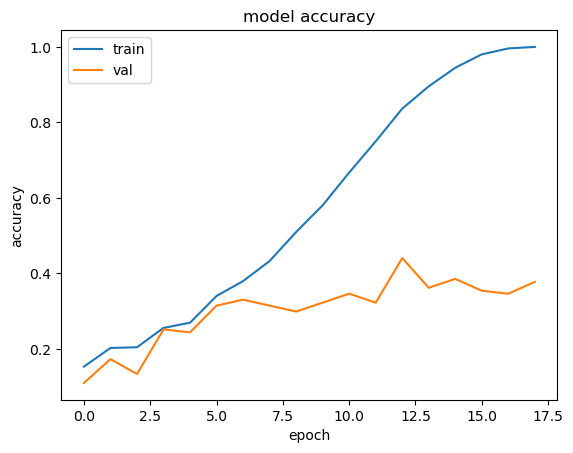

In [66]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

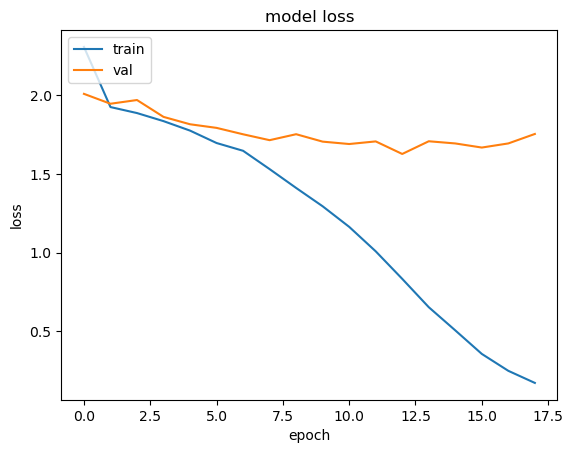

In [67]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [68]:
_, accuracy_test_original = model.evaluate(x_test, y_test)
print('Accuracy on original test data: {:4.2f}%'.format(accuracy_test_original * 100))

4/4 [==============================] - 0s 9ms/step - loss: 1.6266 - accuracy: 0.4409
Accuracy on original test data: 44.09%


Save the model for future computations

In [69]:
model.save('trained_models/EMOVO_CNN_LSTM2.h5')